# Analysis of Beijing Pollution and State Visit Data

The goal of my Master's thesis research is to develop a new methodology to better understand China’s international relations with other countries by tracking air pollution particulate matter readings. There is ample anecdotal evidence that Chinese authorities are able to exert control over pollution. For example, government officials carefully regulated pollution prior to the 2008 Beijing Olympics. This raises the question of whether the government has sought to control the level of pollution during other politically important events. Official visits to China from representatives of foreign governments could be one such type of events. My approach exploits the relationship between daily pollution levels and the timing of diplomatic meetings in Beijing to quantify how the Chinese government views its relations with different countries. Moreover, I also plan to strengthen this causal relationship by exploiting variation in weather patterns and how it relates to air pollution as a natural experiment. 

In [151]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import datetime
import os
import json
import re
import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind
import scipy.stats as sp

%matplotlib inline

# Part I: Pollution data

Data on AQI (air quality index) comes from the US State Department

In [5]:
pollution_data = pd.DataFrame()
for i in range(8,19):
    year = 2000 + i
    filepath = 'data/Beijing_PM2.5_'+str(year)+'_YTD.csv'
    print(filepath)
    pollution_data = pd.concat([pollution_data, pd.read_csv(filepath, encoding='utf-8')])
    
pollution_data['Date (LT)'] = pd.to_datetime(pollution_data['Date (LT)'])
pollution_data = pollution_data.reset_index(drop=True)
pollution_data.drop(pollution_data.tail(1).index,inplace=True) # drop 1 row with 2019 data
pollution_data.tail()

data/Beijing_PM2.5_2008_YTD.csv
data/Beijing_PM2.5_2009_YTD.csv
data/Beijing_PM2.5_2010_YTD.csv
data/Beijing_PM2.5_2011_YTD.csv
data/Beijing_PM2.5_2012_YTD.csv
data/Beijing_PM2.5_2013_YTD.csv
data/Beijing_PM2.5_2014_YTD.csv
data/Beijing_PM2.5_2015_YTD.csv
data/Beijing_PM2.5_2016_YTD.csv
data/Beijing_PM2.5_2017_YTD.csv
data/Beijing_PM2.5_2018_YTD.csv


,Site,Parameter,Date (LT),Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name
96426,Beijing,PM2.5 - Principal,2018-12-31 19:00:00,2018,12,31,19,57.0,152,Unhealthy,59.0,UG/M3,1 Hr,Valid
96427,Beijing,PM2.5 - Principal,2018-12-31 20:00:00,2018,12,31,20,61.0,154,Unhealthy,65.0,UG/M3,1 Hr,Valid
96428,Beijing,PM2.5 - Principal,2018-12-31 21:00:00,2018,12,31,21,61.0,154,Unhealthy,61.0,UG/M3,1 Hr,Valid
96429,Beijing,PM2.5 - Principal,2018-12-31 22:00:00,2018,12,31,22,55.0,149,Unhealthy for Sensitive Groups,49.0,UG/M3,1 Hr,Valid
96430,Beijing,PM2.5 - Principal,2018-12-31 23:00:00,2018,12,31,23,54.4,148,Unhealthy for Sensitive Groups,53.0,UG/M3,1 Hr,Valid


#### Compare line counts of original data files using `$ wc -l <filename>` with shape of dataframe

Each smaller dataframe should have 4 fewer lines, accountings for data descriptions, spacings and headers

In [6]:
# Line check looks good!
8785 + 8761 + 8761 + 8761 + 8785 + 8761 + 8761 + 8761 + 8785 + 8761 + 8760 - 11 #(extra line at the end of each file)

96431

In [7]:
pollution_data = pollution_data.rename(columns={'Site':'site'
                        ,'Parameter':'parameter'
                        ,'Date (LT)':'date_lt'
                        ,'Year':'year'
                        ,'Month':'month'
                        ,'Day':'day'
                        ,'Hour':'hour'
                        ,'NowCast Conc.':'nowcast_conc'
                        ,'AQI':'aqi'
                        ,'AQI Category':'aqi_category'
                        ,'Raw Conc.':'raw_conc'
                        ,'Conc. Unit':'conc_unit'
                        ,'Duration':'duration'
                        ,'QC Name':'qc_name'})
pollution_data.head()

,site,parameter,date_lt,year,month,day,hour,nowcast_conc,aqi,aqi_category,raw_conc,conc_unit,duration,qc_name
0,Beijing,PM2.5 - Principal,2008-01-01 01:00:00,2008,1,1,1,-999.0,-999,NaN,-999.0,UG/M3,1 Hr,Missing
1,Beijing,PM2.5 - Principal,2008-01-01 02:00:00,2008,1,1,2,-999.0,-999,NaN,-999.0,UG/M3,1 Hr,Missing
2,Beijing,PM2.5 - Principal,2008-01-01 03:00:00,2008,1,1,3,-999.0,-999,NaN,-999.0,UG/M3,1 Hr,Missing
3,Beijing,PM2.5 - Principal,2008-01-01 04:00:00,2008,1,1,4,-999.0,-999,NaN,-999.0,UG/M3,1 Hr,Missing
4,Beijing,PM2.5 - Principal,2008-01-01 05:00:00,2008,1,1,5,-999.0,-999,NaN,-999.0,UG/M3,1 Hr,Missing


#### Check how many records are Invalid or Missing

In [8]:
print(pollution_data.groupby('qc_name').size())
print('\nPercent values missing: ', round(6765.0/94968, 3))
print('Percent values invalid: ', round(4037.0/94968, 3)) # negative raw_conc
print('Percent values valid: ', round(84166.0/94968, 3))

qc_name
Invalid     4043
Missing     4413
Valid      87975
dtype: int64

Percent values missing:  0.071
Percent values invalid:  0.043
Percent values valid:  0.886


### Pollution data: Exploratory analysis

#### Fill missing AQI values, and convert date field to datetime type

In [9]:
def fill_missing(x):
    if x < 0:
        return None
    else:
        return x
    
a = fill_missing(-1)
print(a)

None


In [10]:
pollution_data['aqi'] = pollution_data.aqi.apply(fill_missing)
pollution_data[pollution_data.qc_name == 'Missing'] #looks good
pollution_data.head()

,site,parameter,date_lt,year,month,day,hour,nowcast_conc,aqi,aqi_category,raw_conc,conc_unit,duration,qc_name
0,Beijing,PM2.5 - Principal,2008-01-01 01:00:00,2008,1,1,1,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
1,Beijing,PM2.5 - Principal,2008-01-01 02:00:00,2008,1,1,2,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
2,Beijing,PM2.5 - Principal,2008-01-01 03:00:00,2008,1,1,3,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
3,Beijing,PM2.5 - Principal,2008-01-01 04:00:00,2008,1,1,4,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
4,Beijing,PM2.5 - Principal,2008-01-01 05:00:00,2008,1,1,5,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing


##### Hourly pollution readings over time, 2008 through 2018

In [11]:
dates = [pollution_data.date_lt.values]
dates[:5]

[array(['2008-01-01T01:00:00.000000000', '2008-01-01T02:00:00.000000000',
        '2008-01-01T03:00:00.000000000', ...,
        '2018-12-31T21:00:00.000000000', '2018-12-31T22:00:00.000000000',
        '2018-12-31T23:00:00.000000000'], dtype='datetime64[ns]')]

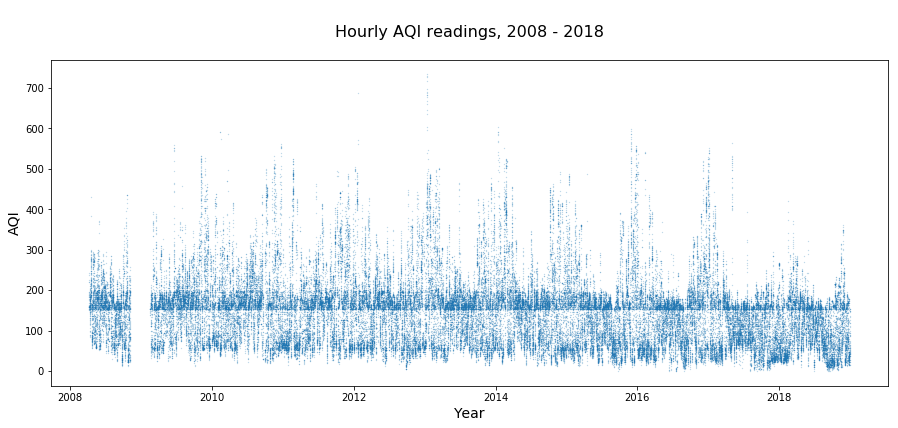

In [12]:
y = pollution_data.aqi

plt.figure(figsize=(15,6))
plt.scatter(dates, y, alpha=0.5, s=.05)
plt.title('\nHourly AQI readings, 2008 - 2018\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI', size=14)
plt.savefig(os.getcwd() + '/img/pollution/1_hourly_aqi_over_time.png')

#### Yearly average coming down over time, from a  peak in 2013

In [13]:
yr_avg_aqi = pollution_data[pollution_data.qc_name == 'Valid'].groupby('year')['aqi'].mean().reset_index()
yr_avg_aqi.head()

,year,aqi
0,2008,151.063257
1,2009,166.381023
2,2010,166.886355
3,2011,160.396297
4,2012,151.744807


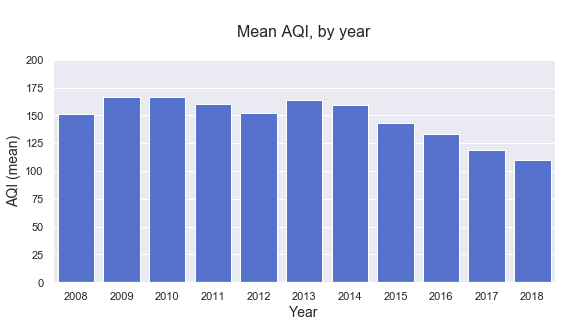

In [14]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="year", y="aqi", data=yr_avg_aqi, kind="bar", aspect=2, size=4, color="royalblue", legend=False
              )

plt.title('\nMean AQI, by year\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.ylim(0,200)
f.savefig(os.getcwd() + '/img/pollution/2_yearly_aqi.png')

##### Winter months tend to be worse, with November highest

In [15]:
mo_avg_aqi = pollution_data[pollution_data.qc_name == 'Valid'].groupby('month')['aqi'].mean().reset_index()
mo_avg_aqi.head()

,month,aqi
0,1,156.286916
1,2,154.327449
2,3,150.428033
3,4,144.201400
4,5,143.319491


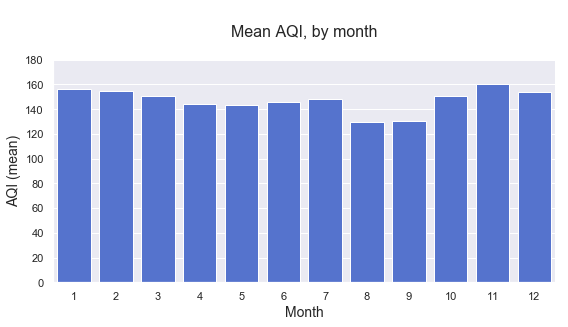

In [16]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="month", y="aqi", data=mo_avg_aqi, kind="bar", aspect=2, size=4, color="royalblue", legend=False)

plt.title('\nMean AQI, by month\n', size=16)
plt.xlabel('Month', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.ylim(0,180)
f.savefig(os.getcwd() + '/img/pollution/3_monthly_aqi.png')

##### Pollution tends to be worse at night

In [17]:
hr_avg_aqi = pollution_data[pollution_data.qc_name == 'Valid'].groupby('hour')['aqi'].mean().reset_index()
hr_avg_aqi.head()

,hour,aqi
0,0,158.161175
1,1,158.203694
2,2,157.171756
3,3,156.164817
4,4,153.839034


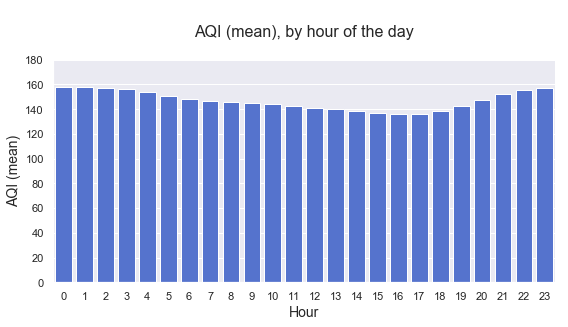

In [18]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="hour", y="aqi", data=hr_avg_aqi, kind="bar", aspect=2, size=4, color="royalblue", legend=False)

plt.title('\nAQI (mean), by hour of the day\n', size=16)
plt.xlabel('Hour', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.ylim(0,180)
f.savefig(os.getcwd() + '/img/pollution/4_hourly_aqi.png')

##### Max AQI values per day, 2008 through 2018

In [19]:
m = pollution_data.groupby(pollution_data.date_lt.apply(lambda x: x.date()))['aqi'].max().reset_index()
m = m.rename(columns={'aqi':'max_aqi'})
m.tail()

,date_lt,max_aqi
4013,2018-12-27,56.0
4014,2018-12-28,43.0
4015,2018-12-29,57.0
4016,2018-12-30,89.0
4017,2018-12-31,154.0


Concentration (ug/m^3) to AQI conversion taken from [AQICN](http://aqicn.org/calculator)

![Screenshot from aqicn.org](https://github.com/yontartu/wuran/raw/master/img/aqicn.png)

Tool to convert color names to RGB. Find named colors [here](https://matplotlib.org/examples/color/named_colors.html).

In [20]:
from matplotlib import colors
colors.hex2color(colors.cnames['salmon'])

(0.9803921568627451, 0.5019607843137255, 0.4470588235294118)

In [21]:
a = m[m.max_aqi <= 12]
b = m[(m.max_aqi > 12) & (m.max_aqi <= 35.5)]
c = m[(m.max_aqi > 35.5) & (m.max_aqi <= 55.5)]
d = m[(m.max_aqi > 55.5) & (m.max_aqi <= 150.5)]
e = m[(m.max_aqi > 150.5) & (m.max_aqi <= 250.5)]
f = m[(m.max_aqi > 250.5) & (m.max_aqi <= 500.5)]
g = m[(m.max_aqi > 500.5)]

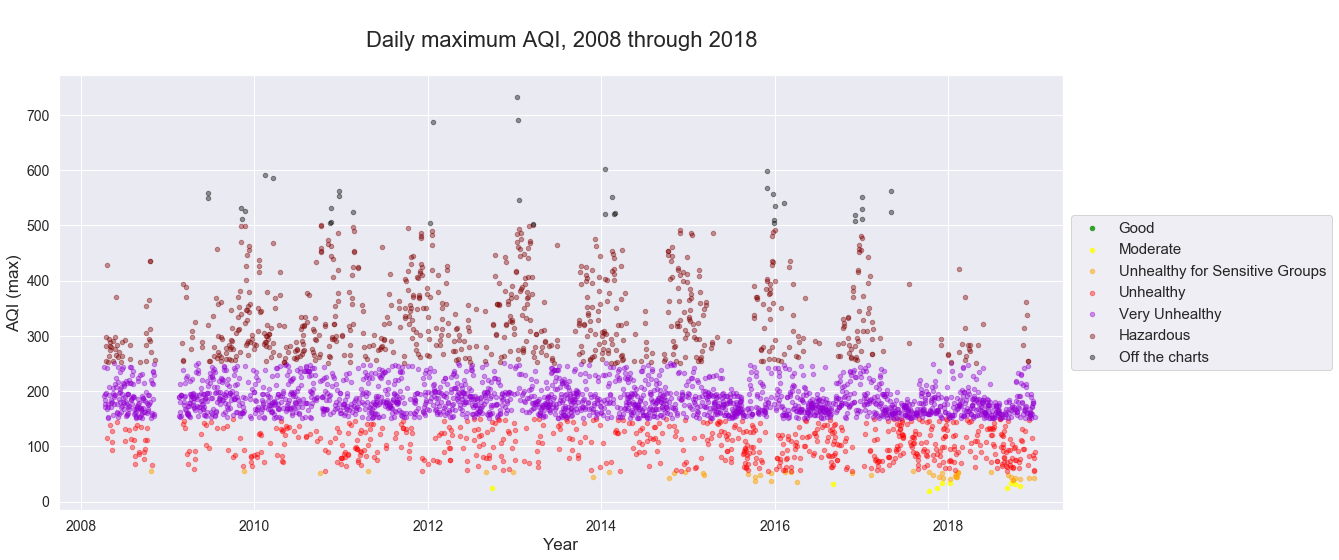

In [22]:
plt.figure(figsize=(18,8))
plt.scatter(list(a.date_lt), a.max_aqi, alpha=1.0, s=20, c=[[0.2, 0.6274509803921569, 0.17254901960784313]], label='Good')
plt.scatter(list(b.date_lt), b.max_aqi, alpha=0.8, s=20, c=[[1.0, 1.0, 0.0]], label='Moderate')
plt.scatter(list(c.date_lt), c.max_aqi, alpha=0.5, s=20, c=[[1.0, 0.6470588235294118, 0.0]], label='Unhealthy for Sensitive Groups')
plt.scatter(list(d.date_lt), d.max_aqi, alpha=0.4, s=20, c=[[1.0, 0.0, 0.0]], label='Unhealthy')
plt.scatter(list(e.date_lt), e.max_aqi, alpha=0.4, s=20, c=[[0.5803921568627451, 0.0, 0.8274509803921568]], label='Very Unhealthy')
plt.scatter(list(f.date_lt), f.max_aqi, alpha=0.4, s=20, c=[[0.5019607843137255, 0.0, 0.0]], label='Hazardous')
plt.scatter(list(g.date_lt), g.max_aqi, alpha=0.4, s=20, c=[[0.0, 0.0, 0.0]], label='Off the charts')
plt.xlim(datetime.date(2007,10,1), datetime.date(2019,5,1))
plt.title('\nDaily maximum AQI, 2008 through 2018\n', size=22)
plt.ylabel('AQI (max)', size=17)
plt.xlabel('Year', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='center right', bbox_to_anchor=(1.275, 0.5), fontsize=15)
plt.savefig(os.getcwd() + '/img/pollution/5_daily_max_aqi.png')

Is the number of **"Good"** and **"Moderate"** days increasing or decreasing? What about the number of **"Unhealthy"** and **"Hazardous"** days?

In [23]:
pollution_data.head()

,site,parameter,date_lt,year,month,day,hour,nowcast_conc,aqi,aqi_category,raw_conc,conc_unit,duration,qc_name
0,Beijing,PM2.5 - Principal,2008-01-01 01:00:00,2008,1,1,1,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
1,Beijing,PM2.5 - Principal,2008-01-01 02:00:00,2008,1,1,2,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
2,Beijing,PM2.5 - Principal,2008-01-01 03:00:00,2008,1,1,3,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
3,Beijing,PM2.5 - Principal,2008-01-01 04:00:00,2008,1,1,4,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
4,Beijing,PM2.5 - Principal,2008-01-01 05:00:00,2008,1,1,5,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing


In [24]:
s = pollution_data.groupby([pollution_data.year, pollution_data.aqi_category]).size().reset_index()
s = s.rename(columns={s.columns[2]:'counts'})
s.head()

,year,aqi_category,counts
0,2008,Good,213
1,2008,Hazardous,37
2,2008,Moderate,911
3,2008,Unhealthy,2224
4,2008,Unhealthy for Sensitive Groups,807


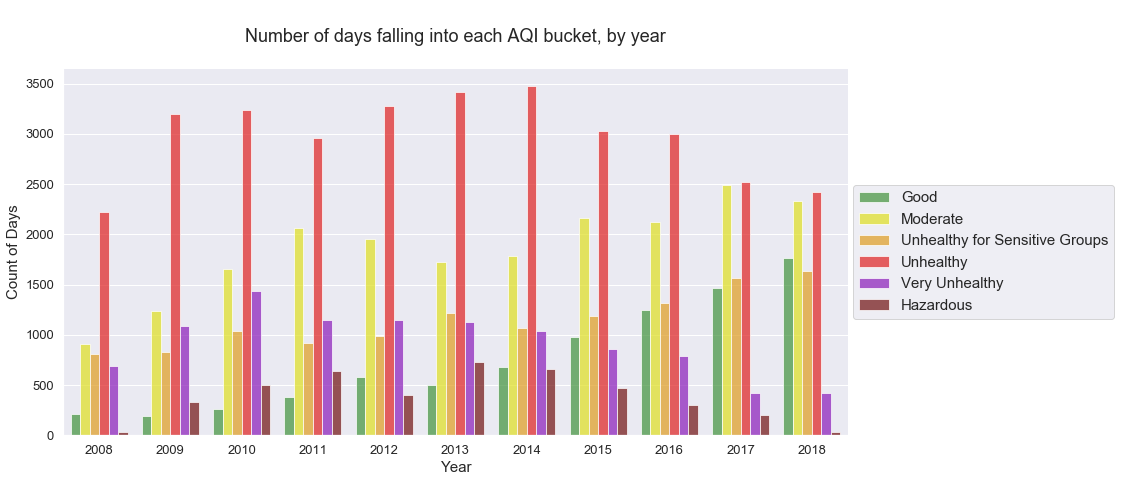

In [25]:
sns.set(style="darkgrid", color_codes=True)

p = sns.set_palette([
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (1.0, 1.0, 0.0),
 (1.0, 0.6470588235294118, 0.0),
 (1.0, 0.0, 0.0),
 (0.5803921568627451, 0.0, 0.8274509803921568),
 (0.5019607843137255, 0.0, 0.0),
 (0.0, 0.0, 0.0)
])


f = sns.factorplot(x="year", y="counts", hue="aqi_category", data=s, kind="bar", aspect=2, size=6, alpha=.7
               , hue_order=['Good','Moderate','Unhealthy for Sensitive Groups','Unhealthy','Very Unhealthy','Hazardous'
                            ]
               , palette=p
               , legend=False
              )

plt.title('\nNumber of days falling into each AQI bucket, by year\n', size=18)
plt.xlabel('Year', size=15)
plt.ylabel('Count of Days', size=15)
plt.xticks(size=13)
plt.yticks(size=13)
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), fontsize=15)
f.savefig(os.getcwd() + '/img/pollution/6_aqi_buckets_by_year.png')

# Part II: State Visit data

Data on state visits comes from chinavitae.com. I constructed my own dataset using a web scraper I built. I also wrote separate Python scripts to scrape foreign officials' titles, and to extract country names from officials' titles.

In [26]:
filename = 'C:data/activity_titles_countries.json'
with open(filename, 'r') as f:
    cv = json.load(f)
print(len(cv)) # 16695 items
cv[2]

16695


{'date': 'January 22, 2019',
 'activity': 'Li Keqiang pledges to promote ties with Cambodia to new high ',
 'location': 'Beijing Municipality',
 'attendees': ['Li Keqiang', '\n\t\t\t\t\t Samdech Hun Sen'],
 'attendees_links': ['index.php?mode=events&type=cv&id=263',
  'index.php?mode=events&type=ncv&sn=Samdech Hun Sen&gn='],
 'source': 'XINHUA Online (English 2010)',
 'topics': ['foreign relations'],
 'foreign_officials': [{'name': 'Samdech Hun Sen',
   'title': 'Cambodian Prime Minister'}],
 'activity_id': 2,
 'matched_countries': ['cambodia'],
 'matched_on': ['nationality']}

#### Convert date field to datetime

In [27]:
for record in cv:
    if record['date'] != None:
        record['date'] = datetime.datetime.strptime(record['date'], '%B %d, %Y').date()
#     print(record)
cv[0]

{'date': datetime.date(2019, 2, 3),
 'activity': 'Zhang Youxia calls for support of strengthening and revitalizing armed forces ',
 'location': 'Beijing Municipality',
 'attendees': ['Zhang Youxia'],
 'attendees_links': ['index.php?mode=events&type=cv&id=4098'],
 'source': 'XINHUA Online (English 2010)',
 'topics': ['domestic politics', 'military'],
 'foreign_officials': [],
 'activity_id': 0,
 'matched_countries': [],
 'matched_on': []}

In [28]:
huwen = []
for record in cv:
    if record['date'] != None:
        if record['date'] < datetime.date(2013,3,14): # CHANGE DATE 
            if any("hu jintao" in a.lower() for a in record['attendees']) or any("wen jiabao" in a.lower() for a in record['attendees']):
                huwen.append(record)
print('len of huwen:', len(huwen))

len of huwen: 3021


In [29]:
xili = []
for record in cv:
    if record['date'] != None:
        if record['date'] >= datetime.date(2013,3,14): # CHANGE DATE
            if any("xi jinping" in a.lower() for a in record['attendees']) or any("li keqiang" in a.lower() for a in record['attendees']):
                xili.append(record)
print('len of xili:', len(xili))

len of xili: 2989


In [30]:
huxiwenli = huwen + xili
len(huxiwenli)

6010

### Create subset of State Visit data for analysis: meetings with the Chinese President or Premier

#### Definition of `hxwl` (shorthand for `huxiwenli`)
1. Contains Hu Jingtao, Xi Jinping, Wen Jiabao or Li Keqiang in the list of attendees (already filtered down to this subset)
2. Number of attendees > 1
3. Number of foreign officials attending > 0 
4. Filter out meetings that did not occur in Beijing (i.e. records with "phone" or "send" or "leave" or "congratulat" or "condolence" or "message" or "greeting" or "return" or "anniversar")
5. Official's title contains a country name

In [32]:
hxwl = []
for record in huxiwenli:
    # condition (2): at least 2 attendees
    if len(record['attendees']) > 1:  

        # condition (3): at least 1 foreign official
        if len(record['foreign_officials']) > 0: 

            # condition (4): meeting actually occurred in beijing
            if "phone" not in record['activity'].lower():
                if "leave" not in record['activity'].lower():
                    if "send" not in record['activity'].lower():
                        if "congratulat" not in record['activity'].lower():
                            if "condolence" not in record['activity'].lower():
                                if "message" not in record['activity'].lower():
                                    if "greeting" not in record['activity'].lower():
                                        if "return" not in record['activity'].lower():
                                            if "anniversar" not in record['activity'].lower():
                                                hxwl.append(record)

print('len of hxwl: ', len(hxwl)) # 1774 records 

len of hxwl:  1774


In [33]:
hxwl_matched = []
hxwl_unmatched = []

for record in hxwl:
    # condition (5): matched on country name
    if len(record['matched_countries']) > 0:
        hxwl_matched.append(record)
    else:
        hxwl_unmatched.append(record)

print('len of hxwl_matched: ', len(hxwl_matched)) # 1597 (used to be 999)
print('len of hxwl_unmatched: ', len(hxwl_unmatched)) # 177 (used to be 105)

len of hxwl_matched:  1597
len of hxwl_unmatched:  177


In [35]:
hxwl_matched[0]

{'date': datetime.date(2011, 4, 18),
 'activity': "Chinese Premier meets Singapore's Senior Minister on bilateral ties",
 'location': 'Beijing Municipality',
 'attendees': ['Wen Jiabao', '\n\t\t\t\t\tChok Tong Goh'],
 'attendees_links': ['index.php?mode=events&type=cv&id=21',
  'index.php?mode=events&type=ncv&sn=Goh&gn=Chok Tong'],
 'source': 'XINHUA Online (China View)',
 'topics': ['foreign relations'],
 'foreign_officials': [{'name': 'Chok Tong Goh',
   'title': 'Senior Minister of Singapore'}],
 'activity_id': 244,
 'matched_countries': ['singapore'],
 'matched_on': ['country']}

### Create alternate subset of State Visit data: all foreign visits (not just with `hxwl`) 

#### Definition of `all_visits` 
2. Number of attendees > 1
3. Number of foreign officials attending > 0 
4. Filter out meetings that did not occur in Beijing (i.e. records with "phone" or "send" or "leave" or "congratulat" or "condolence" or "message" or "greeting" or "return" or "anniversar")
5. Official's title contains a country name

In [36]:
all_visits = []
for record in cv:
    # condition (2): at least 2 attendees
    if len(record['attendees']) > 1:  

        # condition (3): at least 1 foreign official
        if len(record['foreign_officials']) > 0: 

            # condition (4): meeting actually occurred in beijing
            if "phone" not in record['activity'].lower():
                if "leave" not in record['activity'].lower():
                    if "send" not in record['activity'].lower():
                        if "congratulat" not in record['activity'].lower():
                            if "condolence" not in record['activity'].lower():
                                if "message" not in record['activity'].lower():
                                    if "greeting" not in record['activity'].lower():
                                        if "return" not in record['activity'].lower():
                                            if "anniversar" not in record['activity'].lower():
                                                all_visits.append(record)

print('len of all_visits: ', len(all_visits)) # 6488 records 

len of all_visits:  6488


In [37]:
all_visits_matched = []
all_visits_unmatched = []

for record in all_visits:
    # condition (5): matched on country name
    if len(record['matched_countries']) > 0:
        all_visits_matched.append(record)
    else:
        all_visits_unmatched.append(record)

print('len of all_visits_matched: ', len(all_visits_matched)) # 5604 
print('len of all_visits_unmatched: ', len(all_visits_unmatched)) # 884

len of all_visits_matched:  5604
len of all_visits_unmatched:  884


In [38]:
all_visits_matched[10]

{'date': datetime.date(2017, 1, 9),
 'activity': 'China, Uruguay pledge to enhance cooperation via parliamentary exchanges',
 'location': 'Beijing Municipality',
 'attendees': ['Zhang Dejiang', '\n\t\t\t\t\tGerardo Amarilla'],
 'attendees_links': ['index.php?mode=events&type=cv&id=35',
  'index.php?mode=events&type=ncv&sn=Amarilla&gn=Gerardo'],
 'source': 'XINHUA Online (China View)',
 'topics': ['foreign relations'],
 'foreign_officials': [{'name': 'Gerardo Amarilla',
   'title': "President of Chamber of Representatives of Uruguay's National Congress"}],
 'activity_id': 60,
 'matched_countries': ['uruguay'],
 'matched_on': ['country']}

### Construct main dataframe: Each row is 1 unique day between 2003 and 2019

Currently, each row in the `hxwl` dataset is an activity record of a meeting between the Chinese president and foreign officials. For my analysis, I want to construct a dataset where each row corresponds to a unique day, and contains information on all the countries from which representatives met with the Chinese president on that day.

In [39]:
df = pd.DataFrame(hxwl_matched) # convert hxwl_matched to a df
df = df[['date','matched_countries','attendees','foreign_officials','activity', 'activity_id']]
df.head()
print(df.shape)
df[330:335]

(1597, 6)


,date,matched_countries,attendees,foreign_officials,activity,activity_id
330,2005-06-21,[republic of korea],"[Wen Jiabao, Ma Kai, \n\t\t\t\t\t Lee Hae-chan]","[{'name': 'Lee Hae-chan', 'title': 'Prime Mini...",Wen Jiabao held talks with South Korean Prime ...,2741
331,2005-06-21,[jamaica],"[Hu Jintao, \n\t\t\t\t\tPercival Noel James Pa...","[{'name': 'Percival Noel James Patterson', 'ti...",Hu Jintao met with Percival Noel James Patters...,2742
332,2005-06-22,[republic of korea],"[Hu Jintao, \n\t\t\t\t\t Lee Hae-chan]","[{'name': 'Lee Hae-chan', 'title': 'Prime Mini...",Hu Jintao met with South Korean Prime Ministe...,2751
333,2005-06-25,[czech republic],"[Hu Jintao, Tang Jiaxuan, \n\t\t\t\t\tJiri Par...","[{'name': 'Jiri Paroubek', 'title': 'Prime Min...",Hu Jintao met with Czech Prime Minister Jiri P...,2757
334,2005-06-25,[fiji],"[Hu Jintao, Tang Jiaxuan, \n\t\t\t\t\tLaisenia...","[{'name': 'Laisenia Qarase', 'title': 'Prime M...",Hu Jintao met with Fijian Prime Minister Laise...,2759


#### Combine all lists of `matched_countries` on a given date

For example, on Febuary 27, 2003, two meetings with Hu Jintao occured: one with Cuba and one with Russia

In [40]:
df[df.date == datetime.date(2003,2,27)]

,date,matched_countries,attendees,foreign_officials,activity,activity_id
7,2003-02-27,[cuba],"[Hu Jintao, Li Peng, Wen Jiabao, Zhu Rongji, \...","[{'name': 'Fidel Castro', 'title': 'Leader of ...","Hu Jintao held talks with Fidel Castro, Presid...",412
8,2003-02-27,[russia],"[Hu Jintao, Jiang Zemin, Tang Jiaxuan, \n\t\t\...","[{'name': 'Igor Ivanov', 'title': 'Russian For...",Jiang Zemin held talks with Russian Foreign Mi...,414


In [41]:
df = df.groupby('date').agg({'matched_countries': 'sum'})#.reset_index()
df.matched_countries = df.matched_countries.apply(lambda x: list(set(x)))
print(df.shape)
df.head()

(1082, 1)


,matched_countries
date,
2003-02-17,[united states]
2003-02-27,"[russia, cuba]"
2003-03-25,[pakistan]
2003-05-14,[romania]
2003-05-19,[japan]


#### Explode each list of `matched_countries` into separate columns

In [42]:
cos = df['matched_countries'].apply(pd.Series)
cos = cos.rename(columns=lambda x: 'country_'+str(x+1))
cos.head()

,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
date,,,,,,,,,
2003-02-17,united states,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-02-27,russia,cuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-03-25,pakistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-14,romania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-19,japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Merge dataframe with `matched_countries` list with exploded country columns

In [43]:
df = pd.concat([df[:], cos[:]], axis=1)#.shape
df = df.sort_values(by=['date'], ascending=False).reset_index()

In [44]:
print(df.shape)
df.tail()

(1082, 11)


,date,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
1077,2003-05-19,[japan],japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1078,2003-05-14,[romania],romania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1079,2003-03-25,[pakistan],pakistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,2003-02-27,"[russia, cuba]",russia,cuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,2003-02-17,[united states],united states,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Create base df with ALL DAYS from 2019 through 2003

In [45]:
df_basedates = pd.DataFrame({'date':list(reversed(pd.date_range('1/1/2003', '2/3/2019')))})
df_basedates.date = df_basedates.date.apply(lambda x: x.date())
print('shape:', df_basedates.shape)
df_basedates.head()

shape: (5878, 1)


,date
0,2019-02-03
1,2019-02-02
2,2019-02-01
3,2019-01-31
4,2019-01-30


#### Merge base df with country matches

In [46]:
df_merged = pd.merge(df_basedates, df, how='left', on='date')
print('shape:', df_merged.shape)
df_merged.head()

shape: (5878, 11)


,date,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,2019-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Create a `state_visit` variable, that takes value 1 if a state visit occured on that day, 0 otherwise

In [47]:
df_merged['state_visit'] = df_merged.matched_countries.isnull() == False
df_merged['state_visit'] = df_merged['state_visit'].astype(int)
print(df_merged.shape)
df_merged.head()

(5878, 12)


,date,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit
0,2019-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2019-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2019-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2019-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [48]:
df_merged[df_merged.state_visit == True].tail()

,date,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit
5739,2003-05-19,[japan],japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5744,2003-05-14,[romania],romania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5794,2003-03-25,[pakistan],pakistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5820,2003-02-27,"[russia, cuba]",russia,cuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5830,2003-02-17,[united states],united states,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Part III: Merge pollution data with state visits data

In [49]:
pollution = pollution_data.copy()
print('pollution data shape:', pollution.shape)
pollution.head()

pollution data shape: (96431, 14)


,site,parameter,date_lt,year,month,day,hour,nowcast_conc,aqi,aqi_category,raw_conc,conc_unit,duration,qc_name
0,Beijing,PM2.5 - Principal,2008-01-01 01:00:00,2008,1,1,1,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
1,Beijing,PM2.5 - Principal,2008-01-01 02:00:00,2008,1,1,2,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
2,Beijing,PM2.5 - Principal,2008-01-01 03:00:00,2008,1,1,3,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
3,Beijing,PM2.5 - Principal,2008-01-01 04:00:00,2008,1,1,4,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
4,Beijing,PM2.5 - Principal,2008-01-01 05:00:00,2008,1,1,5,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing


#### Calculate mean AQI by day

Each row in the pollution dataset is an hourly observation. I want to aggregate up to the daily level.

In [50]:
avg_aqi_by_day = pollution.groupby(pollution.date_lt.apply(lambda x: x.date()))['aqi'].mean().reset_index()
avg_aqi_by_day = avg_aqi_by_day.rename(columns={'date_lt':'date', 'aqi':'avg_aqi'})
print(avg_aqi_by_day.shape)
avg_aqi_by_day.tail()

(4018, 2)


,date,avg_aqi
4013,2018-12-27,36.125000
4014,2018-12-28,33.000000
4015,2018-12-29,38.458333
4016,2018-12-30,46.875000
4017,2018-12-31,111.208333


#### Calculate max AQI by day

In [51]:
max_aqi_by_day = pollution.groupby(pollution.date_lt.apply(lambda x: x.date()))['aqi'].max().reset_index()
max_aqi_by_day = max_aqi_by_day.rename(columns={'date_lt':'date', 'aqi':'max_aqi'})
print(max_aqi_by_day.shape)
max_aqi_by_day.tail()

(4018, 2)


,date,max_aqi
4013,2018-12-27,56.0
4014,2018-12-28,43.0
4015,2018-12-29,57.0
4016,2018-12-30,89.0
4017,2018-12-31,154.0


#### Merge mean and max AQI dataframes together

In [55]:
avg_max_aqi = pd.merge(avg_aqi_by_day, max_aqi_by_day, how='left',on='date')
print(avg_max_aqi.shape)
avg_max_aqi.head()

(4018, 3)


,date,avg_aqi,max_aqi
0,2008-01-01,NaN,NaN
1,2008-01-02,NaN,NaN
2,2008-01-03,NaN,NaN
3,2008-01-04,NaN,NaN
4,2008-01-05,NaN,NaN


#### Merge AQI dataframe with state visits dataframe

In [56]:
statevisits = df_merged.copy()
print(statevisits.shape)
statevisits.head()

(5878, 12)


,date,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit
0,2019-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2019-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2019-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2019-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [57]:
pollution_statevisits = pd.merge(avg_max_aqi, statevisits, how='left',on='date')
print(pollution_statevisits.shape)
pollution_statevisits.head()

(4018, 14)


,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit
0,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2008-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


#### Reorder columns to make it easier to see key variables of interest

In [59]:
ps = pollution_statevisits.copy()
ps = ps[['date','avg_aqi','max_aqi','state_visit','matched_countries','country_1','country_2','country_3','country_4','country_5','country_6','country_7','country_8','country_9']]
print(ps.shape)
ps.head()

(4018, 14)


,date,avg_aqi,max_aqi,state_visit,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,2008-01-01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-03,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-01-04,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-01-05,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part IV: Import NOAA weather data

In [244]:
noaa_data = pd.DataFrame()
for i in range(8,19):
    year = 2000 + i
    filepath = 'data/noaa/isd_'+str(year)+'.csv'
    print(filepath)
    noaa_data = pd.concat([noaa_data, pd.read_csv(filepath)])

noaa_data.date = pd.to_datetime(noaa_data.date)
noaa_data = noaa_data.reset_index(drop=True)
noaa_data['wind_speed'] = noaa_data['wind_speed'] / 10
print(noaa_data.shape)
noaa_data.tail()

data/noaa/isd_2008.csv
data/noaa/isd_2009.csv
data/noaa/isd_2010.csv
data/noaa/isd_2011.csv
data/noaa/isd_2012.csv
data/noaa/isd_2013.csv
data/noaa/isd_2014.csv
data/noaa/isd_2015.csv
data/noaa/isd_2016.csv
data/noaa/isd_2017.csv
data/noaa/isd_2018.csv
(202492, 5)


,date,wind_speed,wind_direction,wind_speed_quality,wind_obs_type
202487,2018-12-31 21:30:00,2.0,340,1,N
202488,2018-12-31 22:00:00,3.0,350,1,N
202489,2018-12-31 22:30:00,3.0,350,1,N
202490,2018-12-31 23:00:00,2.0,360,1,N
202491,2018-12-31 23:30:00,3.0,360,1,N


In [245]:
noaa_data.describe()

,wind_speed,wind_direction,wind_speed_quality
count,202492.000000,202492.000000,202492.000000
mean,6.131987,343.279097,2.555380
std,57.171005,338.274031,3.166052
min,0.000000,10.000000,1.000000
25%,1.000000,110.000000,1.000000
50%,2.000000,210.000000,1.000000
75%,4.000000,350.000000,1.000000
max,999.900000,999.000000,9.000000


In [301]:
def fill_missing_direction(x):
    if x > 360:
        return None
    else:
        return x
    
print(fill_missing_direction(359))

359


In [306]:
def fill_missing_speed(x):
    if x > 20:
        return None
    else:
        return x
    
print(fill_missing_speed(21))

None


In [308]:
noaa_data['wind_direction'] = noaa_data['wind_direction'].apply(fill_missing_direction)
noaa_data['wind_speed'] = noaa_data['wind_speed'].apply(fill_missing_speed)
noaa_data[noaa_data.wind_speed.isnull()]

,date,wind_speed,wind_direction,wind_speed_quality,wind_obs_type
89159,2013-05-05 21:00:00,NaN,NaN,9,C
89215,2013-05-06 21:00:00,NaN,NaN,9,C
89222,2013-05-07 00:00:00,NaN,NaN,9,C
89593,2013-05-13 15:00:00,NaN,NaN,9,C
90055,2013-05-21 21:00:00,NaN,NaN,9,C
90111,2013-05-22 21:00:00,NaN,NaN,9,C
90153,2013-05-23 15:00:00,NaN,NaN,9,C
90223,2013-05-24 21:00:00,NaN,NaN,9,C
90447,2013-05-28 21:00:00,NaN,NaN,9,C
91104,2013-06-09 15:00:00,NaN,NaN,9,C


In [309]:
pollution_data[pollution_data.aqi.isnull()==False].shape

(88475, 14)

In [310]:
d = pd.merge(pollution_data[['date_lt','aqi']], noaa_data, how='left',left_on='date_lt',right_on='date')
print(d.shape)
d.head()

(112456, 7)


,date_lt,aqi,date,wind_speed,wind_direction,wind_speed_quality,wind_obs_type
0,2008-01-01 01:00:00,NaN,2008-01-01 01:00:00,4.0,360.0,1.0,N
1,2008-01-01 02:00:00,NaN,2008-01-01 02:00:00,8.0,310.0,1.0,N
2,2008-01-01 03:00:00,NaN,2008-01-01 03:00:00,4.0,340.0,1.0,N
3,2008-01-01 04:00:00,NaN,2008-01-01 04:00:00,9.0,310.0,1.0,N
4,2008-01-01 05:00:00,NaN,2008-01-01 05:00:00,8.0,310.0,1.0,N


For cases where there are more than one hourly observation for `wind_speed` or `wind_direction`, take the average of the two

In [311]:
d_gb = d.groupby(['date_lt','aqi'])[['wind_speed','wind_direction']].mean().reset_index()#.shape
print(d_gb.shape)
d_gb.head()

(88475, 4)


,date_lt,aqi,wind_speed,wind_direction
0,2008-04-08 17:00:00,243.0,1.0,NaN
1,2008-04-08 18:00:00,224.0,2.0,40.0
2,2008-04-08 19:00:00,220.0,4.0,340.0
3,2008-04-08 20:00:00,220.0,1.0,350.0
4,2008-04-08 21:00:00,237.0,1.0,20.0


In [312]:
d_gb.describe()

,aqi,wind_speed,wind_direction
count,88475.000000,87462.000000,73830.000000
mean,146.956055,2.781305,181.584044
std,82.429169,2.071352,110.389883
min,0.000000,0.000000,10.000000
25%,80.000000,1.000000,90.000000
50%,154.000000,2.000000,170.000000
75%,182.000000,3.500000,290.000000
max,733.000000,20.000000,360.000000


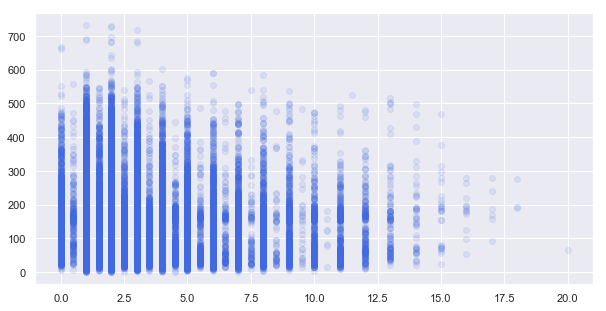

In [325]:
plt.figure(figsize=(10,5))
plt.scatter(d_gb.wind_speed, d_gb.aqi, color='royalblue', alpha=0.1)

In [331]:
d_gbgb = d_gb.groupby(d_gb.date_lt.apply(lambda x: x.date()))[['aqi','wind_speed','wind_direction']].mean()
print(d_gbgb.shape)
d_gbgb.head()

(3764, 3)


,aqi,wind_speed,wind_direction
date_lt,,,
2008-04-08,216.142857,1.857143,220.000000
2008-04-09,162.500000,3.000000,156.666667
2008-04-10,169.583333,3.000000,153.333333
2008-04-11,153.125000,2.708333,199.130435
2008-04-12,141.208333,2.958333,241.666667


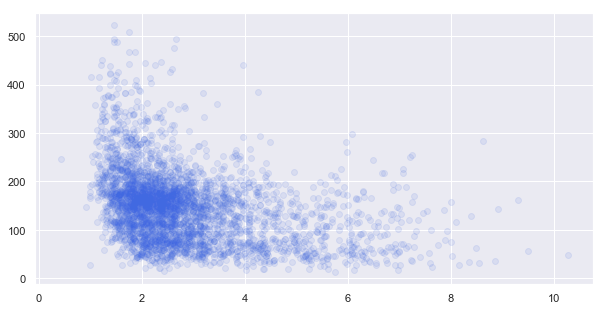

In [332]:
plt.figure(figsize=(10,5))
plt.scatter(d_gbgb.wind_speed, d_gbgb.aqi, color='royalblue', alpha=0.1)

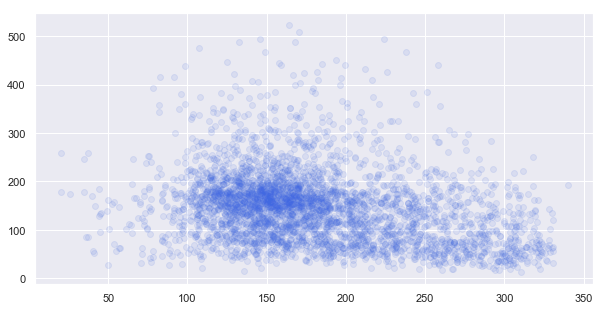

In [333]:
plt.figure(figsize=(10,5))
plt.scatter(d_gbgb.wind_direction, d_gbgb.aqi, color='royalblue', alpha=0.1)

In [207]:
avg_wind_speed_day = noaa_data.groupby(noaa_data.date.apply(lambda x: x.date()))['wind_speed'].mean().reset_index()
print(avg_wind_speed_day.shape)
avg_wind_speed_day.head()

(3992, 2)


,date,wind_speed
0,2008-01-01,39.166667
1,2008-01-02,32.083333
2,2008-01-03,28.000000
3,2008-01-04,16.000000
4,2008-01-05,13.913043


In [208]:
avg_wind_dir_day = noaa_data.groupby(noaa_data.date.apply(lambda x: x.date()))['wind_direction'].mean().reset_index()
print(avg_wind_dir_day.shape)
avg_wind_dir_day.head()

(3992, 2)


,date,wind_direction
0,2008-01-01,413.166667
1,2008-01-02,341.583333
2,2008-01-03,354.280000
3,2008-01-04,312.680000
4,2008-01-05,483.565217


In [212]:
noaa_daily = pd.merge(avg_wind_speed_day, avg_wind_dir_day, on='date', how='left')
print(noaa_daily.shape)
noaa_daily.tail()

(3992, 3)


,date,wind_speed,wind_direction
3987,2018-12-27,89.821429,326.250000
3988,2018-12-28,59.642857,301.071429
3989,2018-12-29,31.964286,255.785714
3990,2018-12-30,16.785714,465.732143
3991,2018-12-31,13.750000,438.642857


In [214]:
noaa_daily.describe()

,wind_speed,wind_direction
count,3992.000000,3992.000000
mean,58.425914,341.888124
std,84.352320,92.657473
min,9.583333,36.250000
25%,20.714286,282.369792
50%,26.875000,336.770833
75%,43.794643,402.223214
max,738.142857,707.058824


# Part V: Import GDP and trade data

# Part VI: Import industrial data from Wind

# Part VII: Analysis

### State visit data: Exploratory analysis

How many days when 0 country representatives in Beijing? How many days with 1 country? 2? etc.

In [60]:
ps.head(3)

,date,avg_aqi,max_aqi,state_visit,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,2008-01-01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-03,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
visit_counts = []
visit_counts.append(ps.country_1.isnull().sum())
for i in range(1,10):
    col = 'country_' + str(i)
    visit_counts.append(((ps[col].isnull() == False).sum()))
visit_counts

[3357, 661, 151, 38, 19, 14, 4, 2, 2, 1]

In [62]:
# labels = ['0 countries','1 country','2 countries','3 countries','4 countries','5 countries','6 countries','7 countries','8 countries','9 countries']
labels = [0,1,2,3,4,5,6,7,8,9]
co_buckets = pd.DataFrame({'bucket':labels, 'num_of_days_co_visits':visit_counts})
co_buckets

,bucket,num_of_days_co_visits
0,0,3357
1,1,661
2,2,151
3,3,38
4,4,19
5,5,14
6,6,4
7,7,2
8,8,2
9,9,1


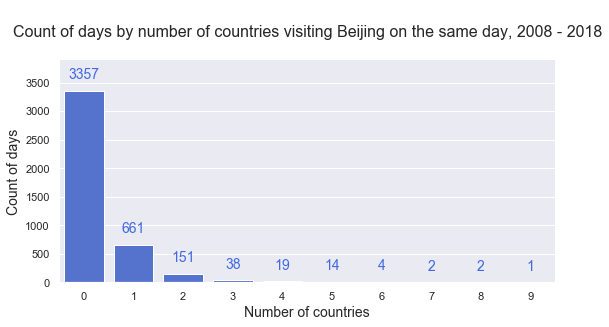

In [63]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="bucket", y="num_of_days_co_visits", data=co_buckets, kind="bar", aspect=2, size=4, color="royalblue", legend=False)

plt.title('\nCount of days by number of countries visiting Beijing on the same day, 2008 - 2018\n', size=16)
plt.xlabel('Number of countries', size=14)
plt.ylabel('Count of days', size=14)
plt.ylim(0,3900)
# plt.yticks([500,1500,3000])

ax = f.ax
for p in ax.patches:
    ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='royalblue', xytext=(0, 16),
                 textcoords='offset points')
f.savefig(os.getcwd() + '/img/chinavitae/1_country_bucket_counts.png')

#### Country visits over time: Which are the top countries coming to Beijing?

In [64]:
countries_raw_data = pd.read_csv('data/countries_clean.csv')
countries_raw_data.head()

,num_code,alpha_2_code,alpha_3_code,country,nationality
0,4,AF,AFG,afghanistan,afghan
1,248,AX,ALA,åland islands,åland island
2,248,AX,ALA,åland islands,aland island
3,8,AL,ALB,albania,albanian
4,12,DZ,DZA,algeria,algerian


In [65]:
xw = pd.DataFrame(countries_raw_data[['nationality','country']]).to_dict()
nationalities = xw['nationality'].values()
countries = xw['country'].values()

Fill `matched_countries` with empty lists `[]` instead of NaN

In [66]:
ps.head(3)

,date,avg_aqi,max_aqi,state_visit,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,2008-01-01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-03,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
for row in ps.loc[ps.matched_countries.isnull(), 'matched_countries'].index:
    ps.at[row, 'matched_countries'] = []
ps.tail()

,date,avg_aqi,max_aqi,state_visit,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
4013,2018-12-27,36.125000,56.0,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4014,2018-12-28,33.000000,43.0,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4015,2018-12-29,38.458333,57.0,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4016,2018-12-30,46.875000,89.0,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,2018-12-31,111.208333,154.0,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Loop through country columns, subset dataframe, then concat together

In [68]:
combined_cos = pd.DataFrame()
for i in range(1,10):
    col_name = 'country_' + str(i)
    a = ps[['date','avg_aqi','max_aqi','state_visit',col_name]]
    a = a[a[col_name].isnull()==False]
    a = a.rename(columns={col_name:'country'})
    combined_cos = pd.concat([combined_cos,a])
combined_cos = combined_cos.reset_index(drop=True)
combined_cos.shape

(892, 5)

In [70]:
combined_cos.head()

,date,avg_aqi,max_aqi,state_visit,country
0,2008-01-10,NaN,NaN,1,philippines
1,2008-01-16,NaN,NaN,1,finland
2,2008-01-18,NaN,NaN,1,republic of korea
3,2008-01-22,NaN,NaN,1,vietnam
4,2008-01-24,NaN,NaN,1,kazakhstan


Add column for whether country is a G20 member

In [71]:
g20 = ['argentina', 'australia', 'brazil', 'canada', 'china','france','germany','india','indonesia','italy','japan','mexico','republic of korea','russia','saudi arabia','south africa','turkey','united kingdom','united states']
g20[:5]

['argentina', 'australia', 'brazil', 'canada', 'china']

In [72]:
combined_cos['g20_member'] = combined_cos.country.apply(lambda x: x in g20)

In [73]:
combined_cos.head()

,date,avg_aqi,max_aqi,state_visit,country,g20_member
0,2008-01-10,NaN,NaN,1,philippines,False
1,2008-01-16,NaN,NaN,1,finland,False
2,2008-01-18,NaN,NaN,1,republic of korea,True
3,2008-01-22,NaN,NaN,1,vietnam,False
4,2008-01-24,NaN,NaN,1,kazakhstan,False


#### Total visits by country, 2008-2018

In [74]:
c = combined_cos.copy()
country_total_visits = c.groupby('country').size().sort_values(ascending=False)#.plot(kind='bar')
country_total_visits = pd.DataFrame({'country':country_total_visits.index, 'counts':country_total_visits.values})
country_total_visits.head(38)

,country,counts
0,united states,79
1,russia,48
2,france,29
3,germany,24
4,republic of korea,23
5,japan,21
6,vietnam,21
7,united kingdom,21
8,laos,19
9,pakistan,19


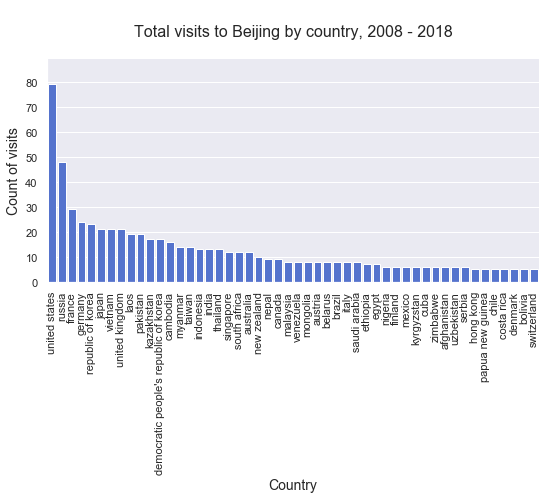

In [82]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="country", y="counts", data=country_total_visits.head(50), kind="bar", aspect=2, size=4, color="royalblue", legend=False)

plt.title('\nTotal visits to Beijing by country, 2008 - 2018\n', size=16)
plt.xlabel('Country', size=14)
plt.ylabel('Count of visits', size=14)
f.set_xticklabels(rotation=90)
plt.ylim(0,89)
f.savefig(os.getcwd() + '/img/chinavitae/2_total_visits_by_country.png')

### Country visits over time, 2008-2018

In [84]:
country_visits_over_time = c.groupby([c.date.apply(lambda x: x.year), c.country]).size()
country_visits_over_time = country_visits_over_time.reset_index()
country_visits_over_time = country_visits_over_time.rename(columns={country_visits_over_time.columns[2]:'counts'})
country_visits_over_time.head()

,date,country,counts
0,2008,algeria,1
1,2008,angola,1
2,2008,australia,1
3,2008,austria,1
4,2008,bangladesh,1


#### United States: Total visits over time

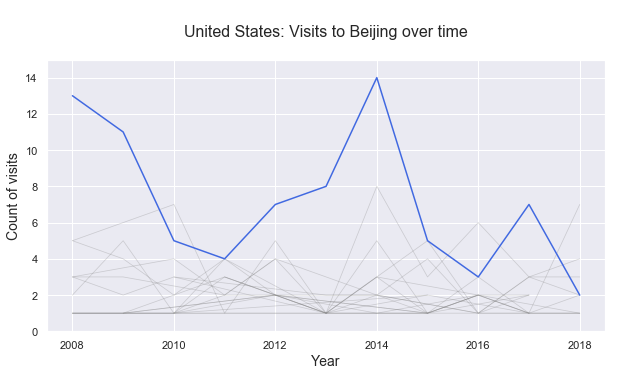

In [96]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'united states':
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=1.0, color="royalblue")
    else:
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=0.3, color="grey", size=14)
plt.title('\nUnited States: Visits to Beijing over time\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('Count of visits', size=14)
plt.ylim(0,15)
plt.savefig(os.getcwd() + '/img/chinavitae/3_usa_visits_over_time.png')

#### Russia: Total visits over time

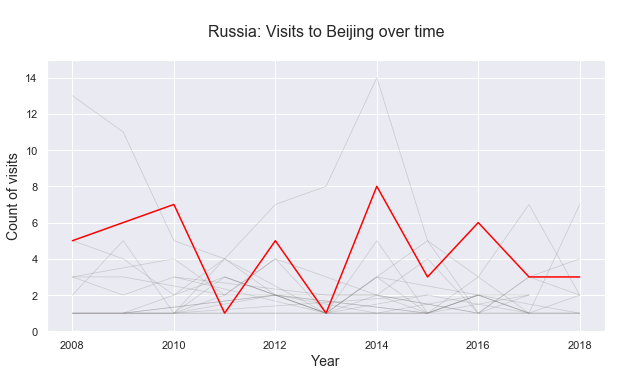

In [93]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'russia':
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=1.0, color="red")#, size=4, color="royalblue", legend=False)
    else:
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)                
plt.title('\nRussia: Visits to Beijing over time\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('Count of visits', size=14)
plt.ylim(0,15)
plt.savefig(os.getcwd() + '/img/chinavitae/4_russia_visits_over_time.png')

#### Japan: Total visits over time

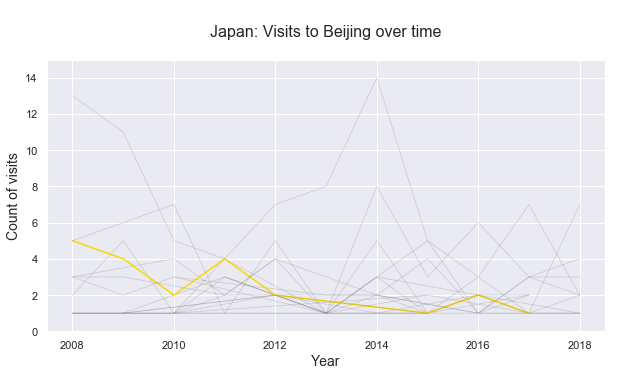

In [97]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'japan':
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=1.0, color="gold")#, size=4, color="royalblue", legend=False)
    else:
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)                
plt.title('\nJapan: Visits to Beijing over time\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('Count of visits', size=14)
plt.ylim(0,15)
plt.savefig(os.getcwd() + '/img/chinavitae/5_japan_visits_over_time.png')

### Average AQI over time, by country

In [98]:
country_aqi_over_time = c.groupby([c.date.apply(lambda x: x.year), c.country, c.g20_member])['avg_aqi'].mean().reset_index()
# country_aqi_over_time = country_aqi_over_time[country_aqi_over_time.g20_member == True]
# country_aqi_over_time['us_flag'] = country_aqi_over_time.country == 'united states'
country_aqi_over_time.head()

,date,country,g20_member,avg_aqi
0,2008,algeria,False,193.458333
1,2008,angola,False,NaN
2,2008,australia,True,169.583333
3,2008,austria,False,52.625000
4,2008,bangladesh,False,163.875000


#### United States: AQI during visits

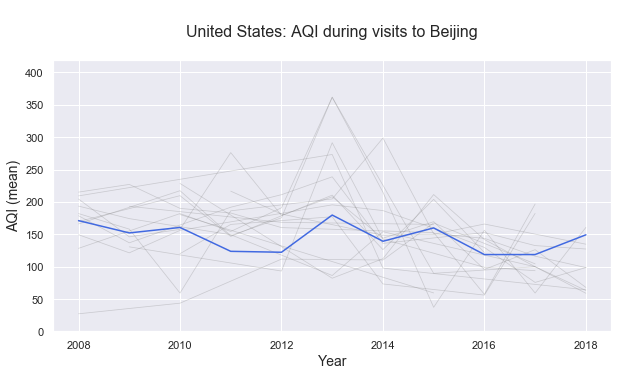

In [99]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'united states':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=1.0, color="royalblue")#, size=4, color="royalblue", legend=False)
    else:
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)
        
plt.title('\nUnited States: AQI during visits to Beijing\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.ylim(0,420)
plt.savefig(os.getcwd() + '/img/chinavitae/6_usa_aqi_during_visits.png')

#### Russia: AQI during visits

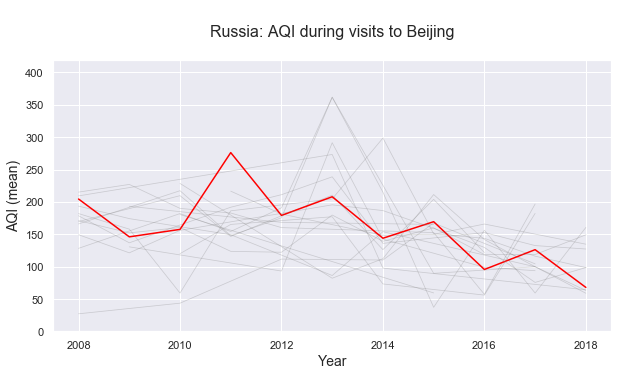

In [100]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'russia':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="red")#, size=4, color="royalblue", legend=False)
    else:
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)
        
plt.title('\nRussia: AQI during visits to Beijing\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI (mean)', size=14)
# plt.legend(loc='center right')#, bbox_to_anchor=(1.275, 0.5), fontsize=15)
plt.ylim(0,420)
plt.savefig(os.getcwd() + '/img/chinavitae/7_russia_aqi_during_visits.png')

#### Japan: AQI during visits    

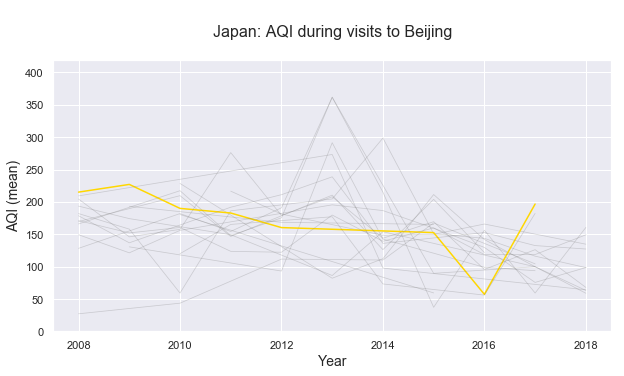

In [101]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'japan':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=1.0, color="gold")#, size=4, color="royalblue", legend=False)
    else:
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)
        
plt.title('\nJapan: AQI during visits to Beijing\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.ylim(0,420)
plt.savefig(os.getcwd() + '/img/chinavitae/8_japan_aqi_during_visits.png')

#### Multiple countries colored

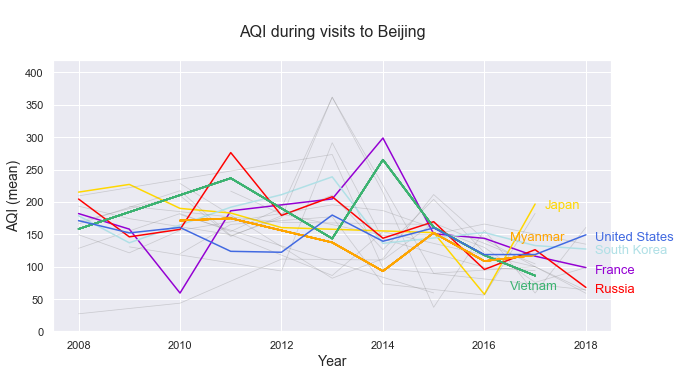

In [123]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'united states':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="royalblue")#, size=4, color="royalblue", legend=False)
    elif country == 'russia':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="red")#, size=4, color="royalblue", legend=False)
    elif country == 'japan':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="gold")#, size=4, color="royalblue", legend=False)
    elif country == 'republic of korea':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="powderblue")#, size=4, color="royalblue", legend=False)
    elif country == 'france':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="darkviolet")#, size=4, color="royalblue", legend=False)
    
    else:
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)
        
        # plot vietnam
        data = country_aqi_over_time[country_aqi_over_time.country == 'vietnam']
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="mediumseagreen")#, size=4, color="royalblue", legend=False)

        # plot myanmar
        data = country_aqi_over_time[country_aqi_over_time.country == 'myanmar']
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="orange")#, size=4, color="royalblue", legend=False)

plt.title('\nAQI during visits to Beijing\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.text(2017.18,190,'Japan', size=13, color='gold')
plt.text(2018.18,140,'United States', size=13, color='royalblue')
plt.text(2018.18,120,'South Korea', size=13, color='powderblue')
plt.text(2018.18,90,'France', size=13, color='darkviolet')
plt.text(2018.18,60,'Russia', size=13, color='red')
plt.text(2016.5,65,'Vietnam', size=13, color='mediumseagreen')
plt.text(2016.5,140,'Myanmar', size=13, color='orange')
plt.ylim(0,420)
plt.savefig(os.getcwd() + '/img/chinavitae/9_multicountry_aqi_during_visits.png')

## Statistical Analysis

#### How does AQI (mean) compare on days with state visits vs. days without state visits?

In [184]:
p = ps.copy()
p = p[p.avg_aqi.isnull()==False]
x = p[p.state_visit==1]
x.shape
y = p[p.state_visit==0]
y.shape

(3134, 14)

In [185]:
t, pval, degrees_freedom = ttest_ind(x['avg_aqi'],y['avg_aqi'])
print('The t-statistic is', t)
print('The p-stat of the t test is', pval)

The t-statistic is 0.7939477555194053
The p-stat of the t test is 0.4272759228367524


In [186]:
means_diff = p.groupby(p.state_visit)[['avg_aqi']].mean().reset_index()
means_diff

,state_visit,avg_aqi
0,0,146.678157
1,1,149.177901


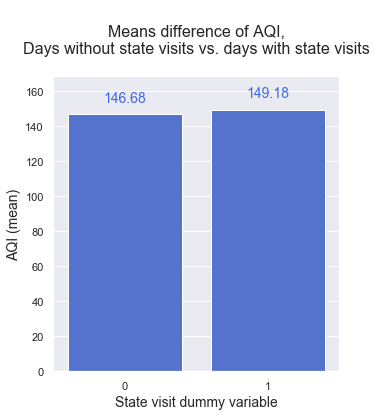

In [187]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="state_visit", y="avg_aqi", data=means_diff, kind="bar", color="royalblue", legend=False)

plt.title('\nMeans difference of AQI,\nDays without state visits vs. days with state visits\n', size=16)
plt.xlabel('State visit dummy variable', size=14)
plt.ylabel('AQI (mean)', size=14)
# f.set_xticklabels(rotation=90)
plt.ylim(0,168)

ax = f.ax
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='royalblue', xytext=(0, 16),
                 textcoords='offset points')
f.savefig(os.getcwd() + '/img/analysis/1_means_diff_aqi.png')

#### United States: T test for means difference

In [195]:
p = ps.copy()
p.shape
p.tail()

,date,avg_aqi,max_aqi,state_visit,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
4013,2018-12-27,36.125000,56.0,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4014,2018-12-28,33.000000,43.0,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4015,2018-12-29,38.458333,57.0,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4016,2018-12-30,46.875000,89.0,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,2018-12-31,111.208333,154.0,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
group0_aqi = p.where(p.state_visit==0)['avg_aqi'].dropna()
group1_aqi = p.where(p.state_visit==1)['avg_aqi'].dropna()

In [202]:
combined_cos.head()

,date,avg_aqi,max_aqi,state_visit,country,g20_member
0,2008-01-10,NaN,NaN,1,philippines,False
1,2008-01-16,NaN,NaN,1,finland,False
2,2008-01-18,NaN,NaN,1,republic of korea,True
3,2008-01-22,NaN,NaN,1,vietnam,False
4,2008-01-24,NaN,NaN,1,kazakhstan,False


In [49]:
ps[ps.country_1 == 'united states'].groupby(ps.state_visit)[['avg_aqi']].mean()

,avg_aqi
state_visit,
1,140.120503


In [50]:
ps[ps.country_1 == 'japan'].groupby(ps.state_visit)[['avg_aqi']].mean()

,avg_aqi
state_visit,
1,181.710938


In [51]:
ps[ps.country_1 == 'russia'].groupby(ps.state_visit)[['avg_aqi']].mean()

,avg_aqi
state_visit,
1,166.64478


## Next Steps:

- Import additional data (i.e. weather data, GDP, trade volumes)
- Continue data exploratoration
- Proceed with statistical modeling (i.e. time series analysis, predict AQI on a given day)